In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
        
from collections import Counter

In [2]:
df = pd.read_csv("./fedex/fedex.csv")
df.shape

(3604175, 15)

In [3]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,Actual_Shipment_Time,Planned_Shipment_Time,Planned_Delivery_Time,Carrier_Name,Carrier_Num,Planned_TimeofTravel,Shipment_Delay,Source,Destination,Distance,Delivery_Status
0,2008,1,3,4,2003.0,1955,2225,WN,335,150.0,8.0,IAD,TPA,810,0.0
1,2008,1,3,4,754.0,735,1000,WN,3231,145.0,19.0,IAD,TPA,810,1.0
2,2008,1,3,4,628.0,620,750,WN,448,90.0,8.0,IND,BWI,515,0.0
3,2008,1,3,4,926.0,930,1100,WN,1746,90.0,-4.0,IND,BWI,515,0.0
4,2008,1,3,4,1829.0,1755,1925,WN,3920,90.0,34.0,IND,BWI,515,1.0


In [4]:
df['Delivery_Status'].value_counts()

0.0    2804359
1.0     718214
Name: Delivery_Status, dtype: int64

<b> Let us plot the Class Distribution </b>

Text(0.5, 1.0, 'Delivery_Status Distributions \n (0: Timely Delivery || 1: Delayed Delivery)')

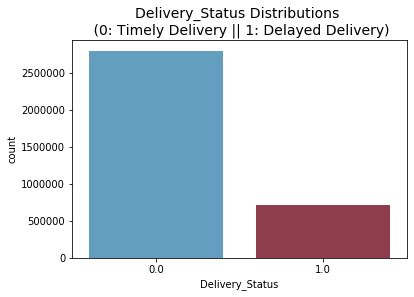

In [5]:
colors = ['#55a3cd', '#9c2f45']

sns.countplot('Delivery_Status', data=df, palette=colors)
plt.title('Delivery_Status Distributions \n (0: Timely Delivery || 1: Delayed Delivery)', fontsize=14)

In [6]:
# The classes are heavily skewed
print('Timely Delivery:', round(df['Delivery_Status'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Delayed Delivery:', round(df['Delivery_Status'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Timely Delivery: 77.81 % of the dataset
Delayed Delivery: 19.93 % of the dataset


## Data Preprocessing:

In [7]:
df.isnull().sum()

Year                         0
Month                        0
DayofMonth                   0
DayOfWeek                    0
Actual_Shipment_Time     81602
Planned_Shipment_Time        0
Planned_Delivery_Time        0
Carrier_Name                 0
Carrier_Num                  0
Planned_TimeofTravel       547
Shipment_Delay           81602
Source                       0
Destination                  0
Distance                     0
Delivery_Status          81602
dtype: int64

### As we can see that there are 81602 null values in Target variable Delivery_Status, we have to drop these observations

In [8]:
df.dropna(subset=['Delivery_Status'], inplace=True)

In [9]:
df.shape

(3522573, 15)

In [10]:
df

,Year,Month,DayofMonth,DayOfWeek,Actual_Shipment_Time,Planned_Shipment_Time,Planned_Delivery_Time,Carrier_Name,Carrier_Num,Planned_TimeofTravel,Shipment_Delay,Source,Destination,Distance,Delivery_Status
0,2008,1,3,4,2003.0,1955,2225,WN,335,150.0,8.0,IAD,TPA,810,0.0
1,2008,1,3,4,754.0,735,1000,WN,3231,145.0,19.0,IAD,TPA,810,1.0
2,2008,1,3,4,628.0,620,750,WN,448,90.0,8.0,IND,BWI,515,0.0
3,2008,1,3,4,926.0,930,1100,WN,1746,90.0,-4.0,IND,BWI,515,0.0
4,2008,1,3,4,1829.0,1755,1925,WN,3920,90.0,34.0,IND,BWI,515,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604170,2008,6,19,4,1059.0,1100,1256,DL,1547,236.0,-1.0,ATL,JAC,1572,0.0
3604171,2008,6,19,4,555.0,600,738,DL,1548,98.0,-5.0,RSW,ATL,515,0.0
3604172,2008,6,19,4,821.0,827,1003,DL,1548,96.0,-6.0,ATL,IND,432,0.0
3604173,2008,6,19,4,718.0,735,852,DL,1551,77.0,-17.0,CAE,ATL,191,0.0


In [11]:
# We can see from the above that though the rows have been dropeed but indexes are going beyond the number of rows left. 
# We need to reset the indexes otherwise it will cause problems when we will try to combine 2 dataframes
df = df.reset_index(drop=True)
df

,Year,Month,DayofMonth,DayOfWeek,Actual_Shipment_Time,Planned_Shipment_Time,Planned_Delivery_Time,Carrier_Name,Carrier_Num,Planned_TimeofTravel,Shipment_Delay,Source,Destination,Distance,Delivery_Status
0,2008,1,3,4,2003.0,1955,2225,WN,335,150.0,8.0,IAD,TPA,810,0.0
1,2008,1,3,4,754.0,735,1000,WN,3231,145.0,19.0,IAD,TPA,810,1.0
2,2008,1,3,4,628.0,620,750,WN,448,90.0,8.0,IND,BWI,515,0.0
3,2008,1,3,4,926.0,930,1100,WN,1746,90.0,-4.0,IND,BWI,515,0.0
4,2008,1,3,4,1829.0,1755,1925,WN,3920,90.0,34.0,IND,BWI,515,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3522568,2008,6,19,4,1059.0,1100,1256,DL,1547,236.0,-1.0,ATL,JAC,1572,0.0
3522569,2008,6,19,4,555.0,600,738,DL,1548,98.0,-5.0,RSW,ATL,515,0.0
3522570,2008,6,19,4,821.0,827,1003,DL,1548,96.0,-6.0,ATL,IND,432,0.0
3522571,2008,6,19,4,718.0,735,852,DL,1551,77.0,-17.0,CAE,ATL,191,0.0


In [12]:
df.isnull().sum()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
Actual_Shipment_Time       0
Planned_Shipment_Time      0
Planned_Delivery_Time      0
Carrier_Name               0
Carrier_Num                0
Planned_TimeofTravel     406
Shipment_Delay             0
Source                     0
Destination                0
Distance                   0
Delivery_Status            0
dtype: int64

<b>BoxPlot: </b>  To identify the presence of outliers before imputing missing values

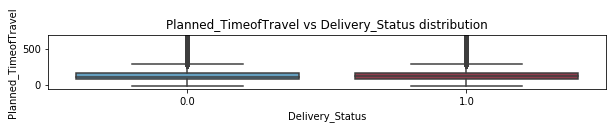

In [13]:
fig, axes = plt.subplots(ncols=1, figsize=(10,1))

sns.boxplot(x="Delivery_Status", y="Planned_TimeofTravel", data=df, palette=colors)
axes.set_title('Planned_TimeofTravel vs Delivery_Status distribution')

plt.show()

<b> From the above box-plot, we can see that Planned_TimeofTravel has outliers so we will impute the values using median </b>

In [14]:
missing_col = ['Planned_TimeofTravel']
 
for i in missing_col:
    df.loc[df.loc[:,i].isnull(),i]=df.loc[:,i].median()

In [15]:
df.isnull().sum()

Year                     0
Month                    0
DayofMonth               0
DayOfWeek                0
Actual_Shipment_Time     0
Planned_Shipment_Time    0
Planned_Delivery_Time    0
Carrier_Name             0
Carrier_Num              0
Planned_TimeofTravel     0
Shipment_Delay           0
Source                   0
Destination              0
Distance                 0
Delivery_Status          0
dtype: int64

In [16]:
# Check whether Carrier_Num attribute has all unique values or it has repeatition
df['Carrier_Num'].value_counts()

16      2524
12      2442
511     2397
152     2315
118     2296
        ... 
9002       1
6792       1
4992       1
6798       1
6794       1
Name: Carrier_Num, Length: 7339, dtype: int64

In [17]:
#df.describe()

In [18]:
df['Year'].dtype

dtype('int64')

In [19]:
df.drop(['Carrier_Name','Source','Destination'], axis=1, inplace = True)

# We would also need to drop deterministic variable Shipment_Delay as it it clear that when Shipment_Delay is more than
# 15 minutes, target variable is set to 1 i.e. Delayed delivery and vice versa
df.drop(['Shipment_Delay'], axis=1, inplace = True)

In [20]:
df

,Year,Month,DayofMonth,DayOfWeek,Actual_Shipment_Time,Planned_Shipment_Time,Planned_Delivery_Time,Carrier_Num,Planned_TimeofTravel,Distance,Delivery_Status
0,2008,1,3,4,2003.0,1955,2225,335,150.0,810,0.0
1,2008,1,3,4,754.0,735,1000,3231,145.0,810,1.0
2,2008,1,3,4,628.0,620,750,448,90.0,515,0.0
3,2008,1,3,4,926.0,930,1100,1746,90.0,515,0.0
4,2008,1,3,4,1829.0,1755,1925,3920,90.0,515,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3522568,2008,6,19,4,1059.0,1100,1256,1547,236.0,1572,0.0
3522569,2008,6,19,4,555.0,600,738,1548,98.0,515,0.0
3522570,2008,6,19,4,821.0,827,1003,1548,96.0,432,0.0
3522571,2008,6,19,4,718.0,735,852,1551,77.0,191,0.0


In [21]:
#character_columns = df[['Year','Month','DayofMonth','DayOfWeek','Carrier_Name', 'Carrier_Num', 'Source', 'Destination','Delivery_Status']]
#fedex_chr_df = character_columns.copy()
#print(fedex_chr_df.head())

#numeric_columns = df[["Actual_Shipment_Time","Planned_Shipment_Time","Planned_Delivery_Time","Planned_TimeofTravel","Shipment_Delay","Distance"]]
#fedex_num_df = numeric_columns.copy()
#print(fedex_num_df.head())


In [22]:
#Since most of our data is already scaled, we need to scale the remaining columns
from sklearn.preprocessing import StandardScaler, RobustScaler

# Let us use RobustScaler as it is less prone to outliers.

#std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['scaled_Year'] = rob_scaler.fit_transform(df['Year'].values.reshape(-1,1))
df['scaled_Month'] = rob_scaler.fit_transform(df['Month'].values.reshape(-1,1))
df['scaled_DayofMonth'] = rob_scaler.fit_transform(df['DayofMonth'].values.reshape(-1,1))
df['scaled_DayofWeek'] = rob_scaler.fit_transform(df['DayOfWeek'].values.reshape(-1,1))

df['scaled_Actual_Shipment_Time'] = rob_scaler.fit_transform(df['Actual_Shipment_Time'].values.reshape(-1,1))
df['scaled_Planned_Shipment_Time'] = rob_scaler.fit_transform(df['Planned_Shipment_Time'].values.reshape(-1,1))
df['scaled_Planned_Delivery_Time'] = rob_scaler.fit_transform(df['Planned_Delivery_Time'].values.reshape(-1,1))
df['scaled_Carrier_Num'] = rob_scaler.fit_transform(df['Carrier_Num'].values.reshape(-1,1))
df['scaled_Planned_TimeofTravel'] = rob_scaler.fit_transform(df['Planned_TimeofTravel'].values.reshape(-1,1))
#df['scaled_Shipment_Delay'] = rob_scaler.fit_transform(df['Shipment_Delay'].values.reshape(-1,1))
df['Distance'] = rob_scaler.fit_transform(df['Distance'].values.reshape(-1,1))

#df.drop(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Actual_Shipment_Time','Planned_Shipment_Time','Planned_Delivery_Time','Carrier_Num', 'Planned_TimeofTravel','Shipment_Delay','Distance'], axis=1, inplace=True)
df.drop(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Actual_Shipment_Time','Planned_Shipment_Time','Planned_Delivery_Time','Carrier_Num', 'Planned_TimeofTravel','Distance'], axis=1, inplace=True)

df.head()

,Delivery_Status,scaled_Year,scaled_Month,scaled_DayofMonth,scaled_DayofWeek,scaled_Actual_Shipment_Time,scaled_Planned_Shipment_Time,scaled_Planned_Delivery_Time,scaled_Carrier_Num,scaled_Planned_TimeofTravel
0,0.0,0.0,-1.0,-0.866667,0.0,0.838308,0.798742,0.889447,-0.414247,0.4875
1,1.0,0.0,-1.0,-0.866667,0.0,-0.715174,-0.735849,-0.649497,0.563471,0.4250
2,0.0,0.0,-1.0,-0.866667,0.0,-0.871891,-0.880503,-0.963568,-0.376097,-0.2625
3,0.0,0.0,-1.0,-0.866667,0.0,-0.501244,-0.490566,-0.523869,0.062120,-0.2625
4,1.0,0.0,-1.0,-0.866667,0.0,0.621891,0.547170,0.512563,0.796084,-0.2625


# Train and Test Split:

In [23]:
x = df.drop(['Delivery_Status'], axis=1)
y = df['Delivery_Status']

In [24]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_

array([0.30340066, 0.26542212, 0.10859485, 0.10747379, 0.10221581,
       0.07761555, 0.03152108, 0.00375615, 0.        ])

In [25]:
0.30340066 + 0.26542212 + 0.10859485 + 0.10747379 + 0.10221581 + 0.07761555 + 0.03152108

0.99624386

### As more than 99% of the variance is explained by first 7 out of 9 Principal components so we will consider those 7 only in our model building

In [26]:
principalComponents

array([[-1.51347093,  0.35075387, -0.65803851, ..., -0.11237933,
         0.01453326,  0.        ],
       [ 1.19825716,  0.16760647,  0.16331259, ..., -0.05601657,
         0.0203344 , -0.        ],
       [ 1.563283  , -0.04600042, -0.95863208, ...,  0.04485061,
         0.01904819, -0.        ],
       ...,
       [ 1.11683953, -0.18514877, -0.28492866, ..., -0.01724138,
         0.00332006,  0.        ],
       [ 1.38601842, -0.37810543, -0.38290124, ...,  0.03269347,
        -0.00337065,  0.        ],
       [ 0.64462595,  0.48526581,  0.03269795, ...,  0.09767283,
         0.15920784,  0.        ]])

In [27]:
principalDf = pd.DataFrame(data = principalComponents)
principalDf

,0,1,2,3,4,5,6,7,8
0,-1.513471,0.350754,-0.658039,0.689365,0.839807,0.008182,-0.112379,0.014533,0.0
1,1.198257,0.167606,0.163313,0.850196,0.915537,0.003141,-0.056017,0.020334,-0.0
2,1.563283,-0.046000,-0.958632,0.638523,0.835090,-0.018868,0.044851,0.019048,-0.0
3,0.896919,-0.291082,-0.558121,0.713459,0.863075,-0.011448,-0.012998,-0.002955,-0.0
4,-0.903420,-0.775221,0.117206,0.838759,0.907146,0.003979,-0.006589,0.037315,-0.0
...,...,...,...,...,...,...,...,...,...
3522568,0.412525,1.348705,0.418620,-0.100881,-0.814863,0.022453,0.049564,-0.033707,0.0
3522569,1.659690,-0.107938,-0.281407,-0.229589,-0.851448,-0.011503,0.014974,-0.023774,0.0
3522570,1.116840,-0.185149,-0.284929,-0.231148,-0.853834,-0.009196,-0.017241,0.003320,0.0
3522571,1.386018,-0.378105,-0.382901,-0.248987,-0.858717,-0.014507,0.032693,-0.003371,0.0


In [28]:
Principal_Component_1 = principalDf[0]
Principal_Component_2 = principalDf[1]
Principal_Component_3 = principalDf[2]
Principal_Component_4 = principalDf[3]
Principal_Component_5 = principalDf[4]
Principal_Component_6 = principalDf[5]
Principal_Component_7 = principalDf[6]

#principalDf.drop([0, 1, 2, 3, 4,5,6,7,8], axis=1, inplace=True)
#principalDf


In [29]:
principalDf.drop([0, 1, 2, 3, 4,5,6,7,8], axis=1, inplace=True)

In [30]:
principalDf.insert(0, 'Principal_Component_1', Principal_Component_1)
principalDf.insert(1, 'Principal_Component_2', Principal_Component_2)
principalDf.insert(2, 'Principal_Component_3', Principal_Component_3)
principalDf.insert(3, 'Principal_Component_4', Principal_Component_4)
principalDf.insert(4, 'Principal_Component_5', Principal_Component_5)
principalDf.insert(5, 'Principal_Component_6', Principal_Component_6)
principalDf.insert(6, 'Principal_Component_7', Principal_Component_7)

principalDf

,Principal_Component_1,Principal_Component_2,Principal_Component_3,Principal_Component_4,Principal_Component_5,Principal_Component_6,Principal_Component_7
0,-1.513471,0.350754,-0.658039,0.689365,0.839807,0.008182,-0.112379
1,1.198257,0.167606,0.163313,0.850196,0.915537,0.003141,-0.056017
2,1.563283,-0.046000,-0.958632,0.638523,0.835090,-0.018868,0.044851
3,0.896919,-0.291082,-0.558121,0.713459,0.863075,-0.011448,-0.012998
4,-0.903420,-0.775221,0.117206,0.838759,0.907146,0.003979,-0.006589
...,...,...,...,...,...,...,...
3522568,0.412525,1.348705,0.418620,-0.100881,-0.814863,0.022453,0.049564
3522569,1.659690,-0.107938,-0.281407,-0.229589,-0.851448,-0.011503,0.014974
3522570,1.116840,-0.185149,-0.284929,-0.231148,-0.853834,-0.009196,-0.017241
3522571,1.386018,-0.378105,-0.382901,-0.248987,-0.858717,-0.014507,0.032693


In [31]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf

,Principal_Component_1,Principal_Component_2,Principal_Component_3,Principal_Component_4,Principal_Component_5,Principal_Component_6,Principal_Component_7,Delivery_Status
0,-1.513471,0.350754,-0.658039,0.689365,0.839807,0.008182,-0.112379,0.0
1,1.198257,0.167606,0.163313,0.850196,0.915537,0.003141,-0.056017,1.0
2,1.563283,-0.046000,-0.958632,0.638523,0.835090,-0.018868,0.044851,0.0
3,0.896919,-0.291082,-0.558121,0.713459,0.863075,-0.011448,-0.012998,0.0
4,-0.903420,-0.775221,0.117206,0.838759,0.907146,0.003979,-0.006589,1.0
...,...,...,...,...,...,...,...,...
3522568,0.412525,1.348705,0.418620,-0.100881,-0.814863,0.022453,0.049564,0.0
3522569,1.659690,-0.107938,-0.281407,-0.229589,-0.851448,-0.011503,0.014974,0.0
3522570,1.116840,-0.185149,-0.284929,-0.231148,-0.853834,-0.009196,-0.017241,0.0
3522571,1.386018,-0.378105,-0.382901,-0.248987,-0.858717,-0.014507,0.032693,0.0


In [32]:
finalDf.isnull().sum()

Principal_Component_1    0
Principal_Component_2    0
Principal_Component_3    0
Principal_Component_4    0
Principal_Component_5    0
Principal_Component_6    0
Principal_Component_7    0
Delivery_Status          0
dtype: int64

In [33]:
pc_x = finalDf.drop(['Delivery_Status'], axis=1)
pc_y = finalDf['Delivery_Status']

In [34]:
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(pc_x, pc_y, train_size=0.7, stratify = y, random_state=100)

In [35]:
y_train.shape, y_test.shape

((2465801,), (1056772,))

In [36]:
y_train.value_counts()/len(y_train)

0.0    0.796111
1.0    0.203889
Name: Delivery_Status, dtype: float64

In [37]:
y_test.value_counts()/len(y_test)

0.0    0.796111
1.0    0.203889
Name: Delivery_Status, dtype: float64

In [38]:
type(y_test)

pandas.core.series.Series

In [39]:
type(X_test)

pandas.core.frame.DataFrame

# Handling class imbalance using SMOTE technique:

In [40]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)

smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0.0: 1963051, 1.0: 502750})
After Counter({0.0: 1963051, 1.0: 1963051})


# Model Building:

In [41]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
aucroc = list()
accuracy = list()

In [42]:
# Test data prediction
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)
    print(type(y_pred))

    print('Confusion Matrix')
    print('='*70)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*70)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*70)
    print(roc_auc_score(y_test, y_prob[:,1]),"\n","\n")
    print('Accuracy Score')
    print('='*70)
    print(accuracy_score(y_test,y_pred),"\n")
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    aucroc.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)
    accuracy.append(accuracy_score(y_test,y_pred))


## Model: Random Forest

### a. Original Unsampled Data

In [43]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

cv = StratifiedKFold(n_splits=4, random_state=100, shuffle=True)

In [44]:

rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

#clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=5, verbose=2)
clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='accuracy', n_jobs=-1, n_iter=10, verbose=2)


In [45]:
clf_RF.fit(X_train, y_train)
clf_RF.best_estimator_

Fitting 4 folds for each of 1 candidates, totalling 4 fits


RandomForestClassifier(max_depth=5, min_samples_split=20, n_estimators=30)

In [46]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'actual')

<class 'numpy.ndarray'>
Confusion Matrix
[[840997    311]
 [212313   3151]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89    841308
         1.0       0.91      0.01      0.03    215464

    accuracy                           0.80   1056772
   macro avg       0.85      0.51      0.46   1056772
weighted avg       0.82      0.80      0.71   1056772
 

AUC-ROC
0.7410229451359633 
 

Accuracy Score
0.7987986055648711 



### b. SMOTE Resampling

In [54]:
clf_RF.fit(X_train_sm, y_train_sm)
clf_RF.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=30)

In [55]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote')

Confusion Matrix
[[655850 185458]
 [ 49960 165504]] 

Classification Report
              precision    recall  f1-score   support

         0.0       0.93      0.78      0.85    841308
         1.0       0.47      0.77      0.58    215464

    accuracy                           0.78   1056772
   macro avg       0.70      0.77      0.72   1056772
weighted avg       0.84      0.78      0.79   1056772
 

AUC-ROC
0.8592341358886686 
 

Accuracy Score
0.777229146873687 



## Plotting Model's Accuracy with Original as well as Balanced data (using SMOTE):

In [56]:
clf_eval_df = pd.DataFrame({'model':model,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'auc-roc':aucroc,
                            'accuracy': accuracy})

In [57]:
clf_eval_df

,model,resample,precision,recall,f1-score,auc-roc,accuracy
0,Random Forest,actual,0.777554,0.236174,0.362302,0.813320,0.830489
1,Random Forest,smote,0.471572,0.768128,0.584380,0.859234,0.777229


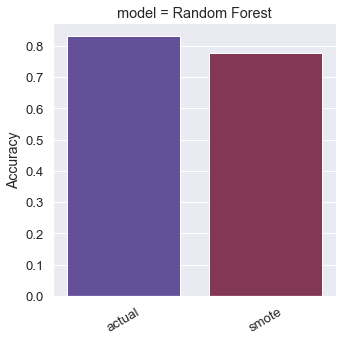

In [58]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "accuracy", palette='twilight', order=["actual", "smote"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('Accuracy', fontsize=14)

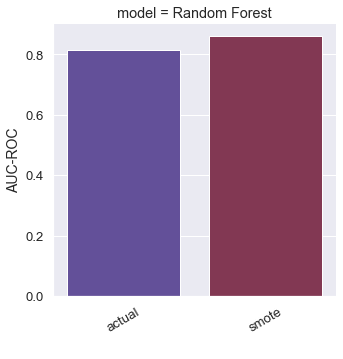

In [59]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "auc-roc", palette='twilight', order=["actual", "smote"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('AUC-ROC', fontsize=14)